# CS-GY 9223-E: Deep Learning Homework 1
Due on Sunday, 11th February 2018, 11:55 PM

This homework can be done in pairs. Everyone must submit on NYU Classes individually.

Write down the UNIs (NetIDs) of your group (if applicable)

Member 1: Name, NetID

Member 2: Name, NetID

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
import glob
import sys
# you shouldn't need to make any more imports

In [9]:
import pickle
# Load the data
print("Loading training and validation datasets... ")
X_train = pickle.load(open("X_train_{}.p".format(datasetName), "rb" ))
y_train = pickle.load(open("y_train_{}.p".format(datasetName), "rb" ))
print("Done!")

Loading training and validation datasets... 
Done!


In [24]:
# modified: __init__
# added: momentum

class NeuralNetwork(object):
    """
    Abstraction of neural network.
    Stores parameters, activations, cached values. 
    Provides necessary functions for training and prediction. 
    """
    def __init__(self, layer_dimensions, drop_prob=0.0, reg_lambda=0.0):
        """
        Initializes the weights and biases for each layer
        :param layer_dimensions: (list) number of nodes in each layer
        :param drop_prob: drop probability for dropout layers. Only required in part 2 of the assignment
        :param reg_lambda: regularization parameter. Only required in part 2 of the assignment
        """
        np.random.seed(1)
    
        self.parameters = {}
        self.num_layers = len(layer_dimensions)-1
        self.drop_prob = drop_prob
        self.reg = reg_lambda
        
        self.epoch = 0
        self.sample = 0
        
        self.momentum = {}
        
        for i in range(self.num_layers):
            std = np.sqrt(2/(layer_dimensions[i+1]+layer_dimensions[i]))
            # weight matrix
            self.parameters['W' + str(i+1)] = std * np.random.randn(layer_dimensions[i+1], layer_dimensions[i])
            # momentum corresponding to weight matrix
            self.momentum['W' + str(i+1)] = np.zeros((layer_dimensions[i+1], layer_dimensions[i]))
            # bias vector
            self.parameters['b' + str(i+1)] = np.zeros([layer_dimensions[i+1],1])
            # momentum corresponding to bias
            self.momentum['b' + str(i+1)] = np.zeros([layer_dimensions[i+1],1])
        # init parameters
        
    def affineForward(self, A, W, b):
        """
        Forward pass for the affine layer.
        :param A: input matrix, shape (L, S), where L is the number of hidden units in the previous layer and S is
        the number of samples
        :returns: the affine product WA + b, along with the cache required for the backward pass
        """
        out = np.dot(W, A) + b
        cache = (out, W, b, A)
        return (out, cache)

    def relu(self, X):
        return np.maximum(X, 0)
    
    def activationForward(self, A, activation="relu"):
        """
        Common interface to access all activation functions.
        :param A: input to the activation function
        :param prob: activation funciton to apply to A. Just "relu" for this assignment.
        :returns: activation(A)
        """
        return getattr(self,activation)(A)


            
    def dropout(self, A, prob):
        """
        :param A: Activation
        :param prob: drop prob
        :returns: tuple (A, M) 
            WHERE
            A is matrix after applying dropout
            M is dropout mask, used in the backward pass
        """
        M = np.random.rand(A.shape[0], A.shape[1])
        M = (M > prob) * 1.0
        scale_up_prob = 1 / (1 - prob)
        M *= scale_up_prob
        A *= M
        
        return A, M

    def forwardPropagation(self, X):
        """
        Runs an input X through the neural network to compute activations
        for all layers. Returns the output computed at the last layer along
        with the cache required for backpropagation.
        :returns: (tuple) AL, cache
            WHERE 
            AL is activation of last layer
            cache is cached values for each layer that
                     are needed in further steps
        """
        cache = {}
        NN_input = {}
        NN_input[str(0)] = X
        for i in range(self.num_layers):
                
                NN_input[str(i+1)], cache_tem = self.affineForward(NN_input[str(i)],self.parameters['W'+str(i+1)],self.parameters['b'+str(i+1)])
                
                if (i+1) != self.num_layers:
                    NN_input[str(i+1)] = self.relu(NN_input[str(i+1)])
                
                cache[str(i+1)] = cache_tem
        
        AL= NN_input[str(self.num_layers)]
        
        return AL, cache

    
    def costFunction(self, AL, y):
        """
        :param AL: Activation of last layer, shape (num_classes, S)
        :param y: labels, shape (S)
        :param alpha: regularization parameter
        :returns cost, dAL: A scalar denoting cost and the gradient of cost
        """
        # compute loss
        N = AL.shape[1]
        shift_scores = AL - np.max(AL, axis=0)
        softmax_scores = np.exp(shift_scores) / np.sum(np.exp(shift_scores), axis=0)
        correct_class_scores = np.choose(y, shift_scores)
        cost = -correct_class_scores + np.log(np.sum(np.exp(shift_scores), axis=0))
        cost = np.sum(cost)
        cost /= N
        if self.reg > 0:
            for i in range(self.num_layers):
                cost += 0.5*self.reg * (np.sum(self.parameters['W'+str(i+1)]**2)+np.sum(self.parameters['b'+str(i+1)]**2))
            # add regularization
       
        # gradient of cost
        dAL = softmax_scores
        dAL[y,range(N)] = dAL[y,range(N)] - 1
        dAL /= N  # Average over batch.
        return cost, dAL

    def affineBackward(self, dA_prev, cache):
        """
        Backward pass for the affine layer.
        :param dA_prev: gradient from the next layer.
        :param cache: cache returned in affineForward
        :returns dA: gradient on the input to this layer
                 dW: gradient on the weights
                 db: gradient on the bias
        """
        out, W, b, A = cache
        dA = np.dot(W.T,dA_prev)
        dW = np.dot(dA_prev,A.T)
        db = np.sum(dA_prev, axis=1)
        db = db[...,np.newaxis]
        return (dA, dW, db)

    def activationBackward(self, dA, cache, activation="relu"):
        """
        Interface to call backward on activation functions.
        In this case, it's just relu. 
        """
        return self.relu_derivative(dA,cache)

        
    def relu_derivative(self, dx, cached_x):
        relu_der = dx
        relu_der[cached_x < 0] = 0
        return relu_der

    def dropout_backward(self, dA, cache):

        return dA

    def backPropagation(self, dAL, Y, cache):
        """
        Run backpropagation to compute gradients on all paramters in the model
        :param dAL: gradient on the last layer of the network. Returned by the cost function.
        :param Y: labels
        :param cache: cached values during forwardprop
        :returns gradients: dW and db for each weight/bias
        """
        gradients = {}

        for i in range(self.num_layers,0,-1):
            if i != 1:
                dA, dW, db=self.affineBackward(dAL,cache[str(i)])
                dAL = self.activationBackward(dA, cache[str(i-1)][0])
            else:
                dAL, dW, db=self.affineBackward(dAL,cache[str(i)])
            gradients['W' + str(i)] = dW
            gradients['b' + str(i)] = db
            #if self.drop_prob > 0:
                #call dropout_backward
        if self.reg > 0:
            for i in range(self.num_layers,0,-1):
                gradients['W' + str(i)] += self.reg * self.parameters['W' + str(i)]
                gradients['b' + str(i)] += self.reg * self.parameters['b' + str(i)]
            #+ self.reg*self.parameters['W'+str(self.num_layers)]
            # add gradients from L2 regularization to each dW
        return gradients

    def updateParameters(self, gradients, alpha, update_rule='SGD'):
        """
        :param gradients: gradients for each weight/bias
        :param alpha: step size for gradient descent 
        """

        getattr(self,update_rule)(gradients, alpha)


    def SGD(self, gradients, alpha):
        for key in self.parameters:
            self.parameters[key] -= alpha * gradients[key]

    def momentum(self, gradients, alpha, beta=0.9):
        for key in self.parameters:
            self.momentum[key] = -(1-beta) * self.gradients[key] + beta*self.momentum[key]
            self.parameters[key] += alpha * self.momentum

    def RMSprop(self, gradients, alpha):
        for key in self.parameters:
            # self.parameters[key] -= alpha * gradients[key]
            pass    
    
    
    def train(self, X, y, X_val, y_val, iters=1000, alpha=0.001, batch_size=100, print_every=100, decay_rate=1):
        """
        :param X: input samples, each column is a sample
        :param y: labels for input samples, y.shape[0] must equal X.shape[1]
        :param iters: number of training iterations
        :param alpha: step size for gradient descent
        :param batch_size: number of samples in a minibatch
        :param print_every: no. of iterations to print debug info after
        """
        
        for i in range(0, iters):
            # get minibatch

            var_batch_size = max(int(4*batch_size*((i+1)/iters)), 32)

            X_mb, y_mb = self.get_batch(X, y, var_batch_size)

            # count epochs
            self.sample += var_batch_size
            if self.sample >= X.shape[1]:
                self.sample = 0
                
                alpha *= decay_rate # decay

            self.epoch += 1


            # X_mb, y_mb = get_batch(X, y, var_batch_size)
            # forward prop
            AL, cache = self.forwardPropagation(X_mb)
            # compute loss
            loss, dAL = self.costFunction(AL, y_mb)
            # compute gradients
            gradients = self.backPropagation(dAL, y_mb, cache) 
#             print(gradients)
#             print("done backproping")
    
            # update weights and biases based on gradient

#             if i==1:
            self.updateParameters(gradients, alpha)
            

            if i % print_every == 0:
                # print cost, train and validation set accuracies
                y_train_pred = self.predict(X_train)
                y_val_pred   = self.predict(X_val)
                val_AL, _    = self.forwardPropagation(X_val)
                val_loss, _  = self.costFunction(val_AL, y_val)
                train_acc    = np.mean(y_train_pred == y_train)
                val_acc      = np.mean(y_val_pred   == y_val)

                print('iter: %d, sample: %d, epoch: %d, cost: %f, train acc: %f, validation acc: %f,\
                    val loss: %f, batch_size %d, alpha: %f' % \
                    (i, self.sample, self.epoch, loss, train_acc, val_acc, val_loss, var_batch_size, alpha) )
               

    def predict(self, X):
        """
        Make predictions for each sample
        """
        AL, cache = NN.forwardPropagation(X)
        
        y_pred = np.argmax(self.softmax(AL), axis=0)
        
        return y_pred


    def get_batch(self, X, y, batch_size):
        """
        Return minibatch of samples and labels
        
        :param X, y: samples and corresponding labels
        :parma batch_size: minibatch size
        :returns: (tuple) X_batch, y_batch
        """
        X_batch = None
        y_batch = None
        random_batch = np.random.permutation(X.shape[1])[0:batch_size]
        X_batch = X[:,random_batch]

        y_batch = y[random_batch]
        return X_batch, y_batch


    
    def softmax(self, X):
        ex = np.exp(X - np.max(X, axis=0))
        return ex / np.sum(ex, axis=0)



In [26]:
# n = 12

# layer_dimensions = [X_train.shape[0], 1024, 10]  # including the input and output layers
# NN = NeuralNetwork(layer_dimensions)

# y_hat = NN.predict(X_train[:, :n])
# y_hat_hard = np.argmax(y_hat, axis=0)

# print(y_hat)
# print(y_hat_hard)

# NN.train(X_train[:, :n], np.hstack((([9]*(n-6)), ([1]*6))), iters=300, alpha=0.0005, batch_size=128, print_every=10)

# # y_hat = NN.predict(X_train[:, :n])
# # y_hat_hard = np.argmax(y_hat, axis=0)

# # print(np.round(y_hat,2))
# print(y_hat_hard)
# # print(y_train[:n])
# # print(np.mean(y_hat_hard == y_train[:n]))

In [27]:
# n = 1000

# layer_dimensions = [X_train.shape[0], 1024, 512, 10]  # including the input and output layers
# NN = NeuralNetwork(layer_dimensions)

# y_hat = NN.predict(X_train[:, :n])
# y_hat_hard = np.argmax(y_hat, axis=0)

# # print(y_hat)
# # print(y_hat_hard)

# NN.train(X_train[:, :n], y_train[:n], iters=1000, alpha=0.05, batch_size=128, print_every=100)

# # y_hat = NN.predict(X_train[:, :n])
# # y_hat_hard = np.argmax(y_hat, axis=0)

# # print(np.round(y_hat,2))
# # print(y_hat_hard)
# # print(y_train[:n])
# # print(np.mean(y_hat_hard == y_train[:n]))

In [19]:
# X = np.hstack( (np.random.randn(10)+5, np.random.randn(10)-5) )
# y = np.array([0]*10 + [1]*10)

# X = np.array([1])
# y = np.array([1])

# print(X.shape, y.shape)

# plt.plot(X, y, 'o')

# X = X[None, :]


# print(X)
# print(y)

# print(X.shape, y.shape)

# layer_dimensions = [1, 2, 2]  # including the input and output layers
# NN = NeuralNetwork(layer_dimensions)
# NN.train(X,y, iters=10, alpha=0.01, batch_size=128, print_every=1)

# # y_hat = NN.predict(X_train[:, :n])
# # y_hat_hard = np.argmax(y_hat, axis=0)

# # print(np.round(y_hat,2))
# # print(y_hat_hard)
# # print(y_train[:n])
# # print(np.mean(y_hat_hard == y_train[:n]))

In [20]:
# Functions to load data, DO NOT change these

def get_labels(folder, label2id):
    """
    Returns vector of labels extracted from filenames of all files in folder
    :param folder: path to data folder
    :param label2id: mapping of text labels to numeric ids. (Eg: automobile -> 0)
    """
    files = get_files(folder)
    y = []
    for f in files:
        y.append(get_label(f,label2id))
    return np.array(y)

def one_hot(y, num_classes=10):
    """
    Converts each label index in y to vector with one_hot encoding
    """
    y_one_hot = np.zeros((num_classes, y.shape[0]))
    y_one_hot[y, range(y.shape[0])] = 1
    return y_one_hot

def get_label_mapping(label_file):
    """
    Returns mappings of label to index and index to label
    The input file has list of labels, each on a separate line.
    """
    with open(label_file, 'r') as f:
        id2label = f.readlines()
        id2label = [l.strip() for l in id2label]
    label2id = {}
    count = 0
    for label in id2label:
        label2id[label] = count
        count += 1
    return id2label, label2id

def get_images(folder):
    """
    returns numpy array of all samples in folder
    each column is a sample resized to 30x30 and flattened
    """
    files = get_files(folder)
    images = []
    count = 0
    
    for f in files:
        count += 1
        if count % 10000 == 0:
            print("Loaded {}/{}".format(count,len(files)))
        img_arr = get_img_array(f)
#         print(img_arr.shape)
        img_arr = img_arr.flatten() / 255.0
        images.append(img_arr)
    X = np.column_stack(images)

    return X

def get_train_data(data_root_path):
    """
    Return X and y
    """
    train_data_path = data_root_path + 'train'
    id2label, label2id = get_label_mapping(data_root_path+'labels.txt')
#     print(label2id)
    X = get_images(train_data_path)
    y = get_labels(train_data_path, label2id)
    return X, y

def save_predictions(filename, y):
    """
    Dumps y into .npy file
    """
    np.save(filename, y)

In [21]:
# Helper functions, DO NOT modify this

def get_img_array(path):
    """
    Given path of image, returns it's numpy array
    """
    return scipy.misc.imread(path)

def get_files(folder):
    """
    Given path to folder, returns list of files in it
    """
    filenames = [file for file in glob.glob(folder+'*/*')]
    filenames.sort()
    return filenames

def get_label(filepath, label2id):
    """
    Files are assumed to be labeled as: /path/to/file/999_frog.png
    Returns label for a filepath
    """
    tokens = filepath.split('/')
    label = tokens[-1].split('_')[1][:-4]
    if label in label2id:
        return label2id[label]
    else:
        sys.exit("Invalid label: " + label)

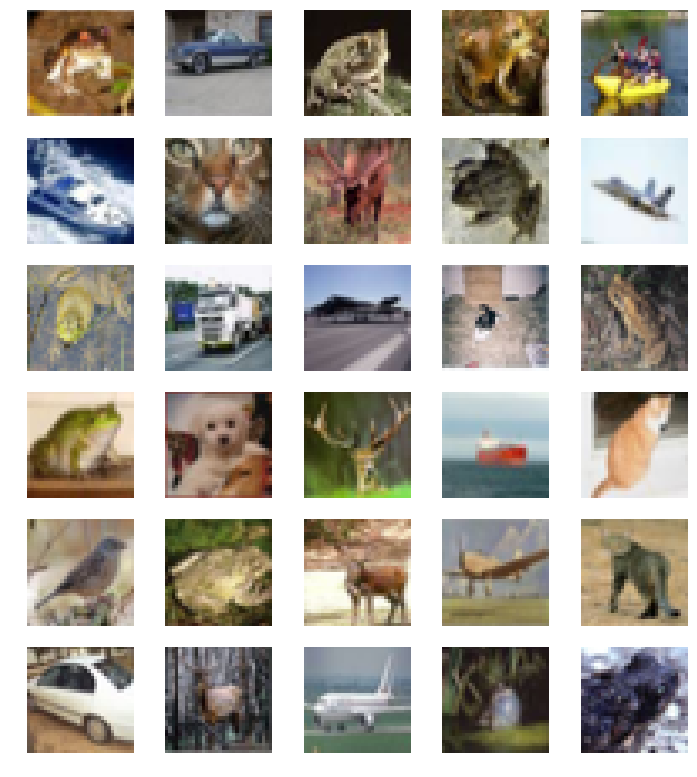

In [22]:
n = 30
# print(X_train[:, :n].shape)
imgs = X_train[:, :n].reshape(32,32,3,-1)
# print(imgs.shape)
plt.figure(figsize=(12,2.5*n/5+1))
plt.axis('off')
for i in range(0, imgs.shape[3]):
    img = imgs[:,:,:,i]
#     print(str(i)+":", img.shape)
    plt.subplot(n/5+1, 5, i+1)
    plt.axis('off')
    plt.imshow(img)

In [ ]:
X_test = get_images(data_root_path + 'test')
print('Data loading done')

In [30]:
# from .py file
total_num=X_train.shape[1]
num_validation=5000
num_training=45000
mask = list(range(num_training, num_training + num_validation))
X_val = X_train[:,mask]
y_val = y_train[mask]
mask = list(range(num_training))
X_train = X_train[:,mask]
y_train = y_train[mask]
mean_image = np.mean(X_train, axis=1)
X_train -= mean_image[:,np.newaxis]
X_train*=2
X_val -= mean_image[:,np.newaxis]
X_val*=2
X_test -= mean_image[:,np.newaxis]
X_test*=2

In [23]:
# import pickle
# # Load the data
# data_root_path = '../HW1/cifar10-hw1/'
# X_train, y_train = get_train_data(data_root_path) # this may take a few minutes
# print("Saving dataset... ")
# datasetName = "main"
# pickle.dump(X_train, open("X_train_{}.p".format(datasetName), "wb" ))
# pickle.dump(y_train, open("y_train_{}.p".format(datasetName), "wb" ))
# # pickle.dump(validation_X, open("validation_X_{}.p".format(datasetName), "wb" ))
# # pickle.dump(validation_y, open("validation_y_{}.p".format(datasetName), "wb" ))

# # pickle.dump(test_y, open("test_y_{}.p".format(datasetName), "wb" ))
# print("Dataset saved!")
# X_test = get_images(data_root_path + 'test')
# pickle.dump(test_X, open("X_test_{}.p".format(datasetName), "wb" ))
# print('Data loading done')


# print("Loading training and validation datasets... ")
# X_train = pickle.load(open("X_train_{}.p".format(datasetName), "rb" ))
# y_train = pickle.load(open("y_train_{}.p".format(datasetName), "rb" ))

# print("Training and validation datasets loaded!")
# print("Loading testing dataset... ")
# X_test = pickle.load(open("test_X_{}.p".format(datasetName), "rb" ))

### run some tests

In [28]:
# layer_dimensions = [X_train.shape[0], 100, 500, 100, 30, 10]  # including the input and output layers
# NN = NeuralNetwork(layer_dimensions)
# # NN.train(X_train, y_train, iters=10, alpha=0, batch_size=128, print_every=10)

# # print([k for k in NN.parameters.keys()])
# # print([v.shape for v in NN.parameters.values()])

# print("weight and bias dimentions and norms")
# print([[k, v[0].shape, v[1].shape] for k,v in NN.parameters.items()])
# print([( np.sum(v[0] ** 2), np.sum(v[1] ** 2)) for k,v in NN.parameters.items()])
# print()

# print("test affineForward")
# A = np.array([[1, 0], [0, 1]])
# W = np.array([[4, 1], 
#      [2, 2]])
# print(NN.affineForward(A, W, np.array([0,0]).T))
# A = np.array([1,1])
# print(A.shape)
# print(NN.affineForward(A, W, np.array([0,0])))

# print("\ntest activation")
# z = [.1, .2, -.2, 1, -1, -1, -1, 1, 1, 1, 2]
# print(z)
# print(NN.relu(z))
# print(NN.activationForward(z))

# print("\n")

# # print(X_train.shape)
# # print(X_train[:, 0].shape)
# # print(X_train[1].shape)


# print("\ntest forward prop")
# AL, cache = NN.forwardPropagation(X_train[:, :10000])
# print("\nAL:", AL.shape)

# print("\n\n")

# print("test cost")
# cost, dAL = NN.costFunction(AL, y_train[:10000])
# print("cost: (", cost, "?=", 2.3, ")  (", np.exp(-cost), "?=", 0.1,")") # cost \approx    2.3  \approx    -log(1/10)     => :-)
# print("\t/\ should be about 2.3 and .1\n\n")

# y_hat = NN.predict(X_train[:, :10000])

# print("\n\ntest predict\n")
# print("predict: \n", y_hat.shape)

# print("\nacc: ", np.mean(np.argmax(y_hat, axis=0) == y_train[:10000]))
# print("\t/\ should be about .1")

# print("\n\n\n", np.row_stack( (y_hat[:, :5], np.sum( y_hat[:, :5], axis=0)) ) )  # last row = 1  => :-)
# print("\t/\ should all add to 1")


#### check the distribution on the outputs

In [29]:
# y_hat.shape
# p = np.argmax(y_hat, axis = 0)
# print(p.shape)
# print("y_", y_hat[:, 1000])

# print(np.argmax(y_hat[:, 1000]))
# print(np.max(y_hat[:, 1000]))

# print("p:", p[1000])
# plt.hist(p)

# print("mean:", np.mean(y_hat, axis=1))
# prob_mass = np.sum(y_hat, axis=1)

# plt.figure()
# plt.hist(prob_mass)

### tests for backward pass

In [ ]:
# print("test cost")
# cost, dAL = NN.costFunction(AL, y_train[:10000])
# print("cost: {0:.2f}".format(cost), "dAL:", dAL)


# # NN.affineBackward()

In [ ]:
# i = 39
# n = 5
# print(y_train[i:i+n])
# print(dAL[:, i:i+n])
# print(np.argmax(y_hat[:, i:i+n], axis=0))
# print(1*(np.equal(y_train[i:i+n], np.argmax(y_hat[:, i:i+n], axis=0))))

# np.sum( np.equal(y_train[:10000], np.argmax(y_hat, axis=0) ) )

## Split train into train and validation sets

In [ ]:
# # X_train = ...
# # y_train = ...

# # X_val   
# # y_val1

# idx = np.random.permutation(len(y_train))
# X_all = X_train[:, idx]
# y_all = y_train[idx]

# m_train = int(len(y_all)*0.9);
# m_val   = len(y_all)-m_train

# X       = X_all[:, :m_train]
# y       = y_all[:m_train]

# X_val   = X_all[:, m_train:]
# y_val   = y_all[m_train:]


In [ ]:
# print(X_all.shape)
# print(y_all.shape)
# print(X.shape)
# print(y.shape)
# print(X_val.shape)
# print(y_val.shape)

# plt.subplot(1,2,1)
# plt.hist(y)
# plt.subplot(1,2,2)
# plt.hist(y_val)

## Part 1

#### Simple fully-connected deep neural network

In [ ]:
# layer_dimensions = [X_train.shape[0], 100, 10]  # including the input and output layers
# NN = NeuralNetwork(layer_dimensions)
# NN.train(X_train, y_train, iters=10, alpha=0, batch_size=128, print_every=1)

layer_dimensions = [X_train.shape[0], 2048, 2048, 1024, 512, 10]  # including the input and output layers
NN = NeuralNetwork(layer_dimensions,drop_prob=0.0, reg_lambda=0)

alpha = 0.01
if len(sys.argv) > 1:
    alpha = float(sys.argv[1])

batch_size = 128
if len(sys.argv) > 2:
    alpha = int(sys.argv[2])

decay_rate = 1.
if len(sys.argv) > 3:
    alpha = float(sys.argv[3])

print("alpha: {}, batch_size: {}, decay_rate: {}".format(alpha, batch_size, decay_rate))

NN.train(X_train, y_train, X_val, y_val, iters=8000, alpha=alpha, batch_size=batch_size, print_every=100,decay_rate=decay_rate)


In [ ]:
y_predicted = NN.predict(X_test)
save_predictions('ans1-uni', y_predicted)

In [ ]:
# test if your numpy file has been saved correctly
loaded_y = np.load('ans1-uni.npy')
print(loaded_y.shape)
loaded_y[:10]

## Part 2: Regularizing the neural network
#### Add dropout and L2 regularization

In [ ]:
NN2 = NeuralNetwork(layer_dimensions, drop_prob=0, reg_lambda=0)
NN2.train(X_train, y_train, iters=1000, alpha=0.00001, batch_size=1000, print_every=10)

In [ ]:
y_predicted2 = NN2.predict(X)
save_predictions(y_predicted, 'ans2-uni')